# studying the brain with naturalistic stimuli
[Functional magnetic resonance imaging (fMRI)](https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging) offers a way to non-invasively record activity throughout the brain in human subjects. It can take tens of thousands of measurements from small (~1-2 mm$^3$) regions of the brain (**voxels**) evey few seconds. Our lab uses this technology to study the brain while people do things that resemble normal human activities. Data from experiments using these "naturalistic" stimuli can tell us things about the brain that are hard to learn from highly synthetic stimuli and behaviors, but can be challenging to analyze.

You're about to work with data collected for a recent experiment performed in our lab. We had subjects do something that comes very naturally to people: listen to stories. One great source for stories is the [The Moth Radio Hour](https://themoth.org/). Since 2009, the show has featured engaging speakers telling personal stories about a wide variety of topics.

# understanding the brain through encoding models
Subjects lay down in the scanner and listened to hours of stories over the course of several sessions while we recorded their brain activity. We analyzed the data using an **encoding model**, that is, a model that takes the stimulus features as input and produces a prediction of brain activity. This result was published in [Huth et al. 2016](http://www.nature.com/nature/journal/v532/n7600/full/nature17637.html).

# decoding the brain
## example: direct decoding
It is also useful to be able to predict the stimulus from the brain activity, often referred to as **brain decoding**. We have tried several methods of brain decoding in our lab with varying degrees of success. Here we show an example in which we simply swap the inputs to the linear model used to perform encoding. That is, whereas in the encoding model we learn linear weights to predict responses from stimuli, in this decoding model (which we refer to as **direct decoding**) we learn linear weights to predict stimuli from the responses. The results are so-so, but should give you an idea for baseline performance against which you can gauge your decoder's success.

We'll split the data into a training and test set, fit the direct decoding on the training set and see how it performs on the test set.

In [3]:
# add some useful code to your python path
import sys, os
import os.path as op
sys.path.append(op.join(os.getcwd(), op.pardir, 'src'))

In [4]:
import numpy as np
import h5py

from matplotlib import pyplot as plt
%matplotlib inline
try: plt.style.use('ggplot')
except: pass

# story names

In [5]:
train_stories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy',
                 'life', 'myfirstdaywiththeyankees', 'naked',
                 'odetostepfather', 'souls']

test_stories = ['undertheinfluence']
all_stories = train_stories + test_stories

# computing stimulus features
The stimuli are stored as [`TextGrid`](http://www.fon.hum.uva.nl/praat/manual/TextGrid.html) files, which is basically a list of words and time stamps for when they occur. We have some helper functions to parse these into a useable format.

In [6]:
from stimulus_utils import load_grids_for_stories, load_generic_trfiles
grids = load_grids_for_stories(all_stories, grid_dir=op.join(op.pardir, 'data/grids'))
trfiles = load_generic_trfiles(all_stories, root=op.join(op.pardir, 'data/trfiles'))

In [7]:
from dsutils import make_word_ds, make_word2vec_model
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}

## semantic vectors
The 2016 paper used a custom word embedding space to generate features from the stimuli. Around the same time the paper came out, [`word2vec`](https://www.tensorflow.org/versions/r0.9/tutorials/word2vec/index.html) hit the streets, and it seems to work just about as well. For generality, we'll use `word2vec` as a feature space for our stimuli. You can download [a pre-trained model from Google](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).

You'll also need to install the python module [`gensim`](https://radimrehurek.com/gensim/) to load and use the model.

In [7]:
## uncomment and run to install
# !python pip install gensim

In [8]:
# download pre-trained model, unzip, and add the path here
semantic_model_path = '/tmp/GoogleNews-vectors-negative300.bin.gz'

from gensim.models.word2vec import Word2Vec
semantic_model = Word2Vec.load_word2vec_format(semantic_model_path,
                                               binary=True)

In [9]:
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in all_stories:
    semanticseqs[story] = make_word2vec_model(wordseqs[story], semantic_model)

In [10]:
interptype = 'lanczos'
downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in all_stories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=3)

we trim ~20 seconds from the beginning and the end to remove artifacts from our detrending method

In [11]:
trim = [10,10]
stimuli = {st:downsampled_semanticseqs[st][trim[0]:-trim[1]]
           for st in all_stories}

## save stimulus features

In [12]:
with h5py.File(op.join(op.pardir, 'data/features.h5'), 'w') as f:
    for story in stimuli:
        f[story] = stimuli[story]

## load pre-computed stimulus features
If you want to concentrate your efforts on decoding instead of designing features, you can download our pre-computed `word2vec` features by running the `download_features.sh` script.

In [ ]:
## uncomment and run to download
#!bash ../download_features.sh

In [14]:
with h5py.File(op.join(op.pardir, 'data/features.h5'), 'r') as f:
    stimuli = {st:f[st].value for st in f}

In [15]:
from ridge.utils import zscore

In [16]:
Xtrain = np.vstack([zscore(stimuli[story], 0)
                    for story in train_stories])
Xtest = np.vstack([zscore(stimuli[story], 0)
                    for story in test_stories])

`Xtrain` and `Xtest` contain the training and test stimulus information. The dimensions are time points x word embedding space dimensions.

In [17]:
print Xtrain.shape, Xtest.shape

(3433, 300) (304, 300)


# responses
We've preprocessed the neural data to save you time. If you haven't run the shell script `download_responses.sh` already, do so now.

In [ ]:
## uncomment and run to download
#!bash ../download_responses.sh

In [ ]:
Ytrain = []
Ytest = []
with h5py.File(op.join(op.pardir, 'data/responses.h5'), 'r') as f:
    for story in train_stories:
        Ytrain.append(zscore(f[story].value))
    for story in test_stories:
        Ytest.append(zscore(f[story].value))
Ytrain = np.nan_to_num(np.vstack(Ytrain))
Ytest = np.nan_to_num(np.vstack(Ytest))

`Ytrain` and `Ytest` contain the training and test response data from one subject. The dimensions are time points x voxels. The sampling period in our fMRI experiments is **2.0045 seconds**.

In [22]:
print Ytrain.shape, Ytest.shape

(3433, 92836) (304, 92836)


The biological signal measured my fMRI is slow to respond to the underlying neural activity that causes it. For this reason, information about the stimulus is available in the responses observed several seconds after the stimulus actually occurs. We delay the responses so that we are predicting the stimulus at each time point from the responses of all voxels from 2 to 8 seconds prior.

In [23]:
from ridge.utils import make_delayed
delays = [-3]
delYtrain = make_delayed(Ytrain, delays)
delYtest = make_delayed(Ytest, delays)

# Sample decoding: direct decoding
To fit this model we use L2-regularized (or ridge) regression. Some optimized code is available from [Alex Huth's github page](https://github.com/alexhuth/ridge.git)

Even fully optimized, this can take a long time to run (and time is of the essence!) so you can download prefit weights by running the script `download_model.sh`.

In [24]:
alpha_range = [2,4]
alphs = np.logspace(*alpha_range, num=15)
nboots = 10 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

model_dir = op.join(op.pardir, 'models')
model_path_fmt = os.path.join(model_dir, 'bsridge-directdecoding'
                              '-alphas{alpha_lo}to{alpha_hi}'
                              '-nboots{nboots}.h5').format

model_path = model_path_fmt(alpha_lo=alpha_range[0], alpha_hi=alpha_range[1],
                            nboots=nboots)
print 'saving model to', model_path

saving model to ../models/bsridge-directdecoding-alphas2to4-nboots10.h5


### run ridge regression

In [ ]:
from ridge import bootstrap_ridge

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delYtrain, Xtrain,
                                                     delYtest, Xtest,
                                                     alphs, nboots,
                                                     chunklen, nchunks,
                                                     singcutoff=1e-10,
                                                     single_alpha=False,
                                                     use_corr=False)

In [67]:
with h5py.File(model_path, 'w') as f:
    f['wt'] = wt
    f['alphas'] = alphas

### load previously run ridge regression parameters

In [ ]:
# uncomment and run to download
!bash ../download_model.sh
model_path = op.join(op.pardir, 'models/bsridge-directdecoding-alphas2to4-nboots10.h5')

In [38]:
with h5py.File(model_path, 'r') as f:
    wt = f['wt'].value
    alphas = f['alphas'].value

### predicting embedding vectors

In [ ]:
Xhat = delYtest.dot(wt)
ntrials_test = delYtest.shape[0]

decoding_perf = np.empty(ntrials_test)
for i in xrange(ntrials_test):
    decoding_perf[i] = np.corrcoef(Xhat[i,:], Xtest[i,:])[0,1]

### De-embedding words
The direct decoding provides us with decoded word embedding vectors, but we actually want to decode the words that the subject heard. We consider the decoded embedding vectors to be the sum of the embedding vectors from the words that we presented and use L1-regularized regression to estimate the sparse matrix of word activations that led to the word embedding vectors. We'll use L1-regularized (LASSO) regression from the [`sklearn`](http://scikit-learn.org/stable/) python package to do this. You can use `pip` to install it.

The vocabulary we'll decode into is provided by wikipedia's list of [1,000 most common english words](https://en.wiktionary.org/wiki/Category:1000_English_basic_words) (at the time we scraped them, there were actually 985 words). To save you time, we've included the list in a text file named `basis_vocabulary.txt`.

In [70]:
## uncomment and run to install sklearn
# !pip install sklearn

In [40]:
basis_vocab = np.loadtxt('basis_vocabulary.txt', str)
basis_vocab_vectors = np.empty((basis_vocab.size, semantic_model.vector_size))
for wi, word in enumerate(basis_vocab):
    try:
        vec = semantic_model[word]
    except KeyError:
        vec = np.zeros(semantic_model.vector_size)
    basis_vocab_vectors[wi,:] = vec

In [41]:
print basis_vocab_vectors.shape, Xhat.shape

(985, 300) (304, 300)


In [42]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, positive=True)
lasso.fit(basis_vocab_vectors.T, Xhat.T)

decoded_words = lasso.coef_

# Results
The output for this simple example will just be a list of words that were deemed most likely to have been present in the original story. That is, we made no attempt to impose correct syntax on the output.

Let's look at the original and decoded text side-by-side. You'll notice a few times where the decoded output comes close to the thematic content of the original, but overall it's not very convincing. We hope you can do better!

In [45]:
test_ws = wordseqs[test_stories[0]]
test_words = test_ws.chunks()[trim[0]:-trim[1]]

for i in xrange(ntrials_test):
    nwds = (decoded_words[i,:]>0).sum()
    word_ix = np.argsort(decoded_words[i,:])[::-1][:nwds]
    print i, ' '.join(test_words[i]), ':::', ' '.join([basis_vocab[i] for i in word_ix][:10])

0 i don't ::: is want kind this be anything something god how seem
1 do it to protect the innocent because i don't know any ::: want may anything not nature is kind hate god fun
2 stories where the people in them are innocent ::: be nature people is kind sad may special city say
3 and i don't do it to be shocking ::: be nature say sad such sound may yes music school
4 either though i admit to ::: i too how lesson sad enjoy what always am possible
5 to once telling a story ::: you i say thing she kind how should may always
6 where i exaggerated the length of my penis ::: her special everybody bird raise music boy hobby report depend
7  ::: mother student evening report music study boy chocolate flower fever
8 in my own defense i exaggerated down and not ::: city will woman nature fear parent be fever school science
9 up and i did it for the laughs ::: if is sweet seem parent story miss say must are
10 you ::: be seem should she parent if sing thing miss difficult
11 the story i'm tellin

-----
# the challenge

Now that you've got an idea for what decoding is and how you might go about it, your challenge is as pretty simple. Design a decoder that considerably outperforms our decoder and you win the prize! Train your decoder using the stimuli and responses for the following stories:
- `alternateithicatom`
- `avatar`
- `howtodraw`
- `legacy`
- `life`
- `myfirstdaywiththeyankees`
- `naked`
- `odetostepfather`
- `souls`
- `undertheinfluence`

And decode the responses in  a prediction for the story we'll evaluate how well it performs on a held-out test story:
 - `TEST`

**Please only use the test story to generate your submission. Do not peak at it to build your decoder.**

# submission format
Run your decoder on the responses stored in the `TEST` field of `responses.h5`. Produce a space-delimited text file in which each line contains the word predictions for a single time point. That is, the text file contains one line per row in the `TEST` response array. Include a blank line if your decoder predicts no output for a given time point. For clarity, we've provided an example submission called `GLABEXAMPLE_decoding_results.txt`

Send an email to `robertg@berkeley.edu` with the subject "`<team_name> 2016 IEEE HACKATHON SUBMISSION`". Include as attachments the following files:
- **`<team_name>_decoding_results.txt`**: the aforementioned space-delimited text file
- **`README.txt`** (or `.pdf`, `.md` if you want to include images or formatting): a document containing a brief description of your approach

# evaluation
We'll evaluate the quality of your decoding using one quantitative and one qualitative method.

### 1. Mean word embedding vector correlation
We'll take the decoded words you submitted for the test story and transform them into the semantic word embedding space. We'll sum the vectors for each time point and compute the correlation coefficient between the summed vector with the semantic vector from the actual story.

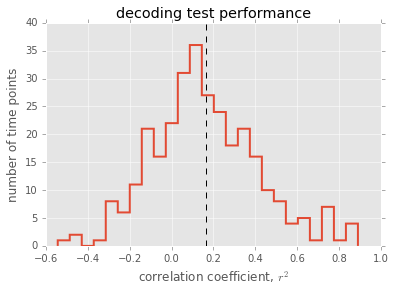

In [46]:
_ = plt.hist(decoding_perf[:-3], 25, histtype='step', lw=2)
_ = plt.title('decoding test performance')
_ = plt.xlabel('correlation coefficient, $r^2$')
_ = plt.ylabel('number of time points')
_ = plt.axvline(decoding_perf[:-3].mean(), color='k', linestyle='--', lw=1)

### 2. Human rating
We'll present human raters with the original passage and output from several submissions including our best and have them judge which of the submissions best matches to the meaning of the original passage.

# Resources
Data and other resources used in this notebook are provided at the following file locations or urls:
- [responses](https://berkeley.box.com/shared/static/znhnewml3snwwio48wkup06um9y6vl9y.h5)
- stimuli (words) (`data/grids`)
 - align with responses using files in (`data/trfiles`)
- [stimuli (features)](https://berkeley.box.com/shared/static/r0b65ge04ypym4xg4epe3yex9sfb2f53.h5)
- 985 common english words vocabulary (`notebooks/basis_vocabulary.txt`)
- [word2vec model](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
- [example decoding model weights](https://berkeley.box.com/shared/static/7a9bey1qudhv2megh138sf5bzyni5rtm.h5)
- [ridge regression code](https://github.com/alexhuth/ridge.git)